# 🌍 Location Cleaning and Country Analysis

This notebook cleans the `location` column from `location.csv`, filters out invalid entries, and maps locations to countries using geopy.

## 1. Install Required Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from country_named_entity_recognition import find_countries
import pycountry
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr
import numpy as np
import os

## 2. Load Eyewitnessing, Tweets, and Location Data

In [ ]:
# Load the three TSV files
earthquakes_df = pd.read_csv('data/crisis_12/labeled_by_authors/earthquakes_eyewitness_annotations_2000.tsv', sep='\t')
floods_df = pd.read_csv('data/crisis_12/labeled_by_authors/floods_eyewitness_annotations_2000.tsv', sep='\t')
hurricanes_df = pd.read_csv('data/crisis_12/labeled_by_authors/hurricanes_eyewitness_annotations_2004.tsv', sep='\t')

# Concatenate the three dataframes into one
combined_crisis_df = pd.concat([earthquakes_df, floods_df, hurricanes_df], ignore_index=True)
combined_crisis_df.head()

,text,label,source,created_at,lang,listed_count,verified,location,statuses_count,followers_count,favourites_count,time_zone,user_lang,friends_count,screen_name,lable,Lable
0,#earthquake Magnitude 2.1 occurred 159km NE of...,non-eyewitness,"<a href=""http://www.didyoufeel.it/"" rel=""nofol...",Tue Aug 01 08:12:42 +0000 2017,en,7.0,f,Italia,92091.0,1248.0,1.0,Central America,en,1756.0,did_you_feel_it,NaN,NaN
1,Retweeted Earthquakes Tsunamis (@NewEarthquake...,non-eyewitness,"<a href=""http://www.facebook.com/twitter"" rel=...",Tue Aug 01 08:13:08 +0000 2017,en,287.0,f,Malaysia,100720.0,1680.0,13260.0,Kuala Lumpur,en,2486.0,LimAiYim,NaN,NaN
2,I always know I need to go shopping when I've ...,don't know,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tue Aug 01 08:13:15 +0000 2017,en,0.0,f,"Hollywood, California, USA..... planet earth",2206.0,89.0,959.0,NaN,en,85.0,3DennisCarlins,NaN,NaN
3,Update: M2.0 #earthquake (#sismo) strikes 1 km...,non-eyewitness,"<a href=""http://www.emsc-csem.org/"" rel=""nofol...",Tue Aug 01 08:13:48 +0000 2017,en,392.0,f,"BruyÃ¨res-Le-Chatel, France",98956.0,8970.0,1.0,Belgrade,fr,3.0,EMSC,NaN,NaN
4,ã€,non-eyewitness,"<a href=""http://twdesk.com/"" rel=""nofollow"">ã",Tue Aug 01 08:14:58 +0000 2017,en,54.0,f,With everyone,265090.0,4165.0,29.0,Irkutsk,ja,3800.0,from___japan,NaN,NaN


## 3. Remove Invalid ROW

In [ ]:
# Drop rows where 'location' or 'text' is null
df = combined_crisis_df.dropna(subset=['location', 'text'])

# Optional: strip whitespace
df['location'] = df['location'].astype(str).str.strip()
df['text'] = df['text'].astype(str).str.strip()

# Only reserve real disaster
df = df[df['target'] == 1]

## 4. Geocode Locations to Countries

In [ ]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize geolocator (for reverse geocoding cities to countries)
geolocator = Nominatim(user_agent="geo_trial")

# Function to preprocess text (lemmatization + normalization)
def preprocess_location(location):
    if pd.isna(location) or not isinstance(location, str):
        return None  # Return None for NaN or non-string entries

    doc = nlp(location.lower())  # Convert to lowercase for case-insensitive comparison
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    return lemmatized_text

# Handle special cases (return None for special terms)
def clean_special_cases(location):
    if pd.isna(location):
        return None  # Return None if location is NaN

    special_terms = ['everywhere', 'earth', 'worldwide', 'universe', 'galaxy', 'na']
    location = location.lower()
    for term in special_terms:
        if term in location:
            return None  # Return None for non-country terms
    return location

# Function to extract countries using geopy
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from geopy.adapters import AdapterHTTPError
import time

def get_country_from_geocode(location, retries=3, delay=10):
    for attempt in range(retries):
        try:
            geocode_result = geolocator.geocode(location, language='en', timeout=10)
            if geocode_result:
                reverse = geolocator.reverse((geocode_result.latitude, geocode_result.longitude), language='en', timeout=10)
                if reverse and 'address' in reverse.raw:
                    return reverse.raw['address'].get('country', None)
            return None
        except (GeocoderTimedOut, GeocoderServiceError, AdapterHTTPError) as e:
            print(f"[{attempt+1}/{retries}] Geocoding failed for '{location}' due to {type(e).__name__}. Retrying in {delay}s...")
            time.sleep(delay)
    return None  

# Function to extract countries using pycountry (for matching from preprocessed location text)
def get_country_from_pycountry(location):
    for country in pycountry.countries:
        if country.name.lower() in location:
            return country.name
    return None

# Main function to extract the country
def get_country(location):
    # Clean the location text for special cases
    location = clean_special_cases(location)
    if not location:  # If it's a special case, return None
        return None

    # First, attempt to get the country using geocoding
    country_name = get_country_from_geocode(location)
    if country_name:
        return country_name

    # If geocoding doesn't work, fall back to pycountry for string matching
    preprocessed_location = preprocess_location(location)
    if preprocessed_location:
        country_name = get_country_from_pycountry(preprocessed_location)
        if country_name:
            return country_name
    
    return None

In [ ]:
import time
from geopy.exc import GeocoderServiceError

# Initialize geolocator
geolocator = Nominatim(user_agent="geo_trial")

# 3. Get country with try and error control
def safe_get_country(location, retries=5, delay=10):
    for attempt in range(retries):
        try:
            if not isinstance(location, str) or location.strip() == "":
                return None
            loc = geolocator.geocode(location, language='en', timeout=10)
            if loc:
                reverse = geolocator.reverse((loc.latitude, loc.longitude), language='en', timeout=10)
                if reverse and 'address' in reverse.raw:
                    return reverse.raw['address'].get('country', None)
            return None
        except GeocoderServiceError as e:
            print(f"[Retry {attempt+1}/{retries}] Geocoder error: {e} for location '{location}'")
            time.sleep(delay)
        except Exception as e:
            print(f"[Retry {attempt+1}/{retries}] Unexpected error: {e}")
            time.sleep(delay)
    return None

# Finding where we did not get the country
last_done_idx = combined_crisis_df[combined_crisis_df['country'].notnull()].index.max()
start_idx = last_done_idx + 1 if pd.notnull(last_done_idx) else 0

# Processing rest
for idx, row in tqdm(combined_crisis_df.iterrows(), total=combined_crisis_df.shape[0]):
    if idx < start_idx:
        continue  # jump over processed

    location = row['location']
    country = safe_get_country(location)
    combined_crisis_df.at[idx, 'country'] = country

    if idx % 50 == 0:
        combined_crisis_df.to_csv("progress_backup.csv", index=False)
        print(f"Progress saved at index {idx}")


## 5. Loading Hofstede dataset

In [ ]:
# Reading
hofstede_df = pd.read_csv("hofstede_dim.csv", sep=';')

# Mapping between data set country and Hofstede country name
alias_map = {
    
    "United Arab Emirates": "Arab countries",  
    "South Korea": "Korea South",
    "Cameroon": "Africa West",
    "Dunan": None,  
    "Sudan": "Arab countries",
    "Haiti": "Africa West", 
    "Central African Republic": "Africa Central",
    "Nepal": "Asia East",  
    "Bahamas": "Latin America", 
    "Madagascar": "Africa East",
    "Gabon": "Africa West",
    "Falkland Islands": None,
    "Saint Lucia": "Latin America",
    "Barbados": "Latin America",
    "Kenya": "Africa East",
    "Bosnia and Herzegovina": "Eastern Europe",
    "Myanmar": "Asia East",
    "Chad": "Africa Central",
    "Honduras": "Latin America",
    "Czechia": "Czech Republic",
    "Sierra Leone": "Africa West",
    "Cuba": "Latin America",
    "Mongolia": None,
    "Namibia": "Africa West",
    "Afghanistan": "Asia East",
    "Bolivia": "Latin America",
    "Cayman Islands": None,
    "Malawi": "Africa East",
    "Oman": "Arab countries",
    "Sri Lanka": "Asia East",
    "Jersey": "United Kingdom",
    "Bahrain": "Arab countries",
    "Botswana": "Africa West",
    "Cambodia": "Asia East",
    "Kuwait": "Arab countries",
    "Kazakhstan": "Russia",
    "Cape Verde": "Africa West"

}

alias_reverse_map = {alias: std for std, aliases in alias_map.items() for alias in aliases}

# make them consistent
hofstede_df['country'] = hofstede_df['country'].replace(alias_reverse_map)
hofstede_df['country'] = hofstede_df['country'].str.strip()

# process null value
for col in ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']:
    hofstede_df[col] = pd.to_numeric(hofstede_df[col], errors='coerce')

# extract usefull columns
hofstede_cleaned = hofstede_df[['country', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']]


                                                text           label  \
0  #earthquake Magnitude 2.1 occurred 159km NE of...  non-eyewitness   
1  Retweeted Earthquakes Tsunamis (@NewEarthquake...  non-eyewitness   
2  I always know I need to go shopping when I've ...      don't know   
3  Update: M2.0 #earthquake (#sismo) strikes 1 km...  non-eyewitness   
4                                                 ã€  non-eyewitness   

                                              source  \
0  <a href="http://www.didyoufeel.it/" rel="nofol...   
1  <a href="http://www.facebook.com/twitter" rel=...   
2  <a href="https://mobile.twitter.com" rel="nofo...   
3  <a href="http://www.emsc-csem.org/" rel="nofol...   
4      <a href="http://twdesk.com/" rel="nofollow">ã   

                       created_at lang listed_count verified  \
0  Tue Aug 01 08:12:42 +0000 2017   en          7.0        f   
1  Tue Aug 01 08:13:08 +0000 2017   en        287.0        f   
2  Tue Aug 01 08:13:15 +0000 2017   en

## 6. Emotion detection

In [ ]:
# Emotional detection model
emotion_clf = pipeline(
    'text-classification',
    model='j-hartmann/emotion-english-distilroberta-base',
    return_all_scores=True
)

def get_emotion_scores(text):
    if not isinstance(text, str): text = ""
    result = emotion_clf(text[:512])[0]  # top 512 chars
    return {item['label']: item['score'] for item in result}

tqdm.pandas()
emotion_scores = df['text'].progress_apply(get_emotion_scores).apply(pd.Series)

# Combine emotion score
df_emo = pd.concat([df, emotion_scores], axis=1)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/toidi/anaconda3/envs/myenv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 6010/6010 [09:04<00:00, 11.03it/s]  


In [ ]:
# Join Two set together
joined_df_final = df_emo.merge(hofstede_cleaned, on='country', how='left')

# Printing to inspect
print(joined_df_final.head())

joined_df_final.to_excel('final_results_joint_emo_cleaned.xlsx')

                                                text           label  \
0  #earthquake Magnitude 2.1 occurred 159km NE of...  non-eyewitness   
1  Retweeted Earthquakes Tsunamis (@NewEarthquake...  non-eyewitness   
2  I always know I need to go shopping when I've ...      don't know   
3  Update: M2.0 #earthquake (#sismo) strikes 1 km...  non-eyewitness   
4                                                 ã€  non-eyewitness   

                                              source  \
0  <a href="http://www.didyoufeel.it/" rel="nofol...   
1  <a href="http://www.facebook.com/twitter" rel=...   
2  <a href="https://mobile.twitter.com" rel="nofo...   
3  <a href="http://www.emsc-csem.org/" rel="nofol...   
4      <a href="http://twdesk.com/" rel="nofollow">ã   

                       created_at lang listed_count verified  \
0  Tue Aug 01 08:12:42 +0000 2017   en          7.0        f   
1  Tue Aug 01 08:13:08 +0000 2017   en        287.0        f   
2  Tue Aug 01 08:13:15 +0000 2017   en

## 6. Final Processing (Throw Unueful Rows)

In [ ]:
df_process = pd.read_excel('final_results_joint_emo_cleaned.xlsx')

# Delete unusable raws
df_process = df_process.dropna(subset=['location', 'text'])
df_process = df_process[df_process['label'].str.lower() != "don't know"]
df_process = df_process[df_process['location'].str.lower() != "earth"]
df_process = df_process[df_process['location'].str.lower() != "worldwide"]
df_process = df_process.dropna(subset=culture_cols, how='all')
df_process['location_lower'] = df_process['location'].astype(str).str.lower().str.strip()

# Further masking
mask_valid = (~df_process['country'].isna()) & \
             (df_process['country'].astype(str).str.strip() != '') & \
             (df_process['location_lower'] != 'global')


df_further_final = df_process[mask_valid]

# Delete unrelated data columns
if 'surprise' in df_further_final.columns:
    surprise_idx = df_further_final.columns.get_loc('surprise')
    df_further_final = df_further_final.iloc[:, :surprise_idx + 1]

## 7. Plotting

#### Correlation

Direct-eyewitness samples: 207
Non-eyewitness samples:    110


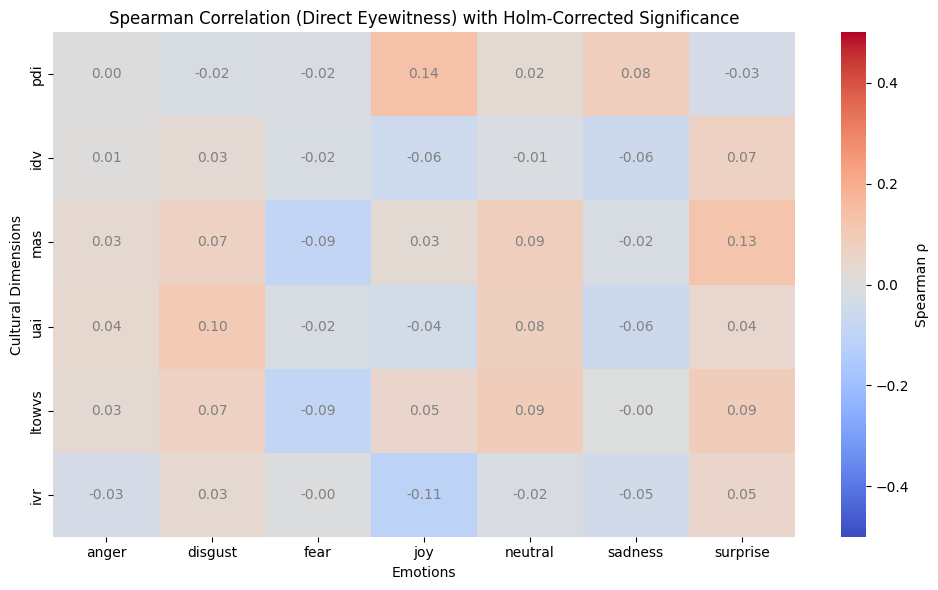

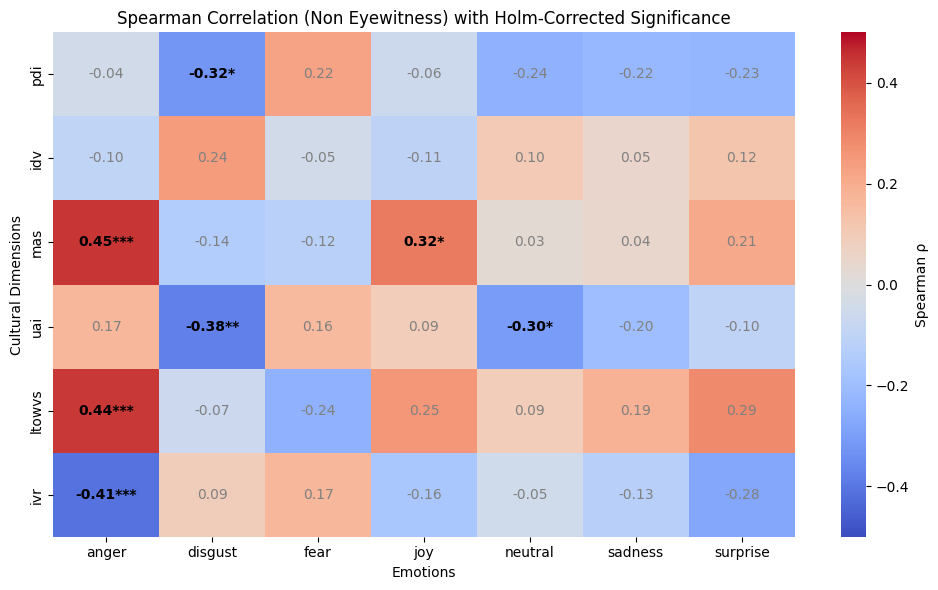

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests


df_further_final = pd.read_excel('data_cleaned_final_official.xlsx')
# Culture and emotion columns
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
culture_cols = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']

# Filter valid columns
def filter_valid_cols(df, cols):
    return [col for col in cols if col in df.columns and df[col].nunique() > 1]

culture_cols = filter_valid_cols(df_further_final, culture_cols)
emotion_cols = filter_valid_cols(df_further_final, emotion_cols)

# Filter and drop NA
df_direct = df_further_final[df_further_final['label'] == 'direct-eyewitness'].dropna(subset=culture_cols + emotion_cols)
df_non    = df_further_final[df_further_final['label'] == 'non-eyewitness'].dropna(subset=culture_cols + emotion_cols)

print(f"Direct-eyewitness samples: {len(df_direct)}")
print(f"Non-eyewitness samples:    {len(df_non)}")

def plot_corr_heatmap_holm(df, title, alpha_levels=[0.05, 0.01, 0.001], vmin=-0.5, vmax=0.5):
    # 1. Compute rho and p-values
    rho_list = []
    pval_list = []
    row_idx = []
    col_idx = []
    
    for cult in culture_cols:
        for emo in emotion_cols:
            rho, p = spearmanr(df[cult], df[emo])
            rho_list.append(rho)
            pval_list.append(p)
            row_idx.append(cult)
            col_idx.append(emo)

    # 2. Apply Holm-Bonferroni correction
    reject, pval_corrected, _, _ = multipletests(pval_list, alpha=0.05, method='holm')

    # 3. Reconstruct matrices
    corr_matrix = pd.DataFrame(index=culture_cols, columns=emotion_cols, dtype=float)
    p_matrix_raw = pd.DataFrame(index=culture_cols, columns=emotion_cols, dtype=float)
    p_matrix_corr = pd.DataFrame(index=culture_cols, columns=emotion_cols, dtype=float)
    sig_matrix = pd.DataFrame(index=culture_cols, columns=emotion_cols, dtype=bool)

    for rho, p_raw, p_corr, rej, r, c in zip(rho_list, pval_list, pval_corrected, reject, row_idx, col_idx):
        corr_matrix.loc[r, c] = rho
        p_matrix_raw.loc[r, c] = p_raw
        p_matrix_corr.loc[r, c] = p_corr
        sig_matrix.loc[r, c] = rej

    # 4. Plot heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        corr_matrix,
        annot=False,
        cmap='coolwarm',
        center=0,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Spearman ρ'}
    )

    # 5. Annotate significance stars based on corrected p-values
    for i, cult in enumerate(culture_cols):
        for j, emo in enumerate(emotion_cols):
            rho = corr_matrix.loc[cult, emo]
            p_corr = p_matrix_corr.loc[cult, emo]

            if pd.isna(rho) or pd.isna(p_corr):
                continue

            # Significance level
            stars = ''
            if p_corr < alpha_levels[0]:
                stars = '*'
            if p_corr < alpha_levels[1]:
                stars = '**'
            if p_corr < alpha_levels[2]:
                stars = '***'

            # Formatting
            text = f"{rho:.2f}{stars}"
            color = 'black' if p_corr < 0.05 else 'gray'
            weight = 'bold' if p_corr < 0.05 else 'normal'

            ax.text(
                j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color=color,
                fontsize=10,
                fontweight=weight
            )

    plt.title(f"Spearman Correlation ({title}) with Holm-Corrected Significance")
    plt.xlabel("Emotions")
    plt.ylabel("Cultural Dimensions")
    plt.tight_layout()
    plt.savefig(f"spearman_correlation_{title.lower().replace(' ', '_')}_holm_corrected.png", dpi=300)
    plt.show()

    return corr_matrix, p_matrix_raw, p_matrix_corr, sig_matrix

# Run the updated function
corr_direct, _, _, _ = plot_corr_heatmap_holm(df_direct, "Direct Eyewitness")
corr_non,    _, _, _ = plot_corr_heatmap_holm(df_non,    "Non Eyewitness")


### Function of individual couple

In [ ]:
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests

# Set file paths
input_path = "significant_spearman_correlations.xlsx"
output_path = "significant_spearman_correlations_Holm.xlsx"

# 1. Read the Excel file
df = pd.read_excel(input_path)

# 2. Extract raw p-values
raw_pvals = df['p_value'].values

# 3. Apply Holm-Bonferroni correction for multiple testing
reject, corrected_pvals, _, _ = multipletests(raw_pvals, alpha=0.05, method='holm')

# 4. Add corrected p-values and significance indicator to the DataFrame
df['p_value_corrected'] = corrected_pvals
df['significant_corrected'] = reject

# 5. Optionally filter for results that remain significant after correction
df_significant = df[df['significant_corrected']]

# 6. Save the filtered results to a new Excel file
df_significant.to_excel(output_path, index=False)

# 7. Print completion message
print(f"Holm-Bonferroni correction completed. {len(df_significant)} significant results saved to: {output_path}")

### Causal analysis: Instrumental Variable

In [31]:
df_further_final = pd.read_excel('data_cleaned_final_official.xlsx')

df = df_further_final.copy()
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
culture_cols = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']
all_cols = emotion_cols + culture_cols
df = df.dropna(subset=['label'] + culture_cols + emotion_cols)
df['is_direct'] = (df['label'] == 'direct-eyewitness').astype(int)

from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


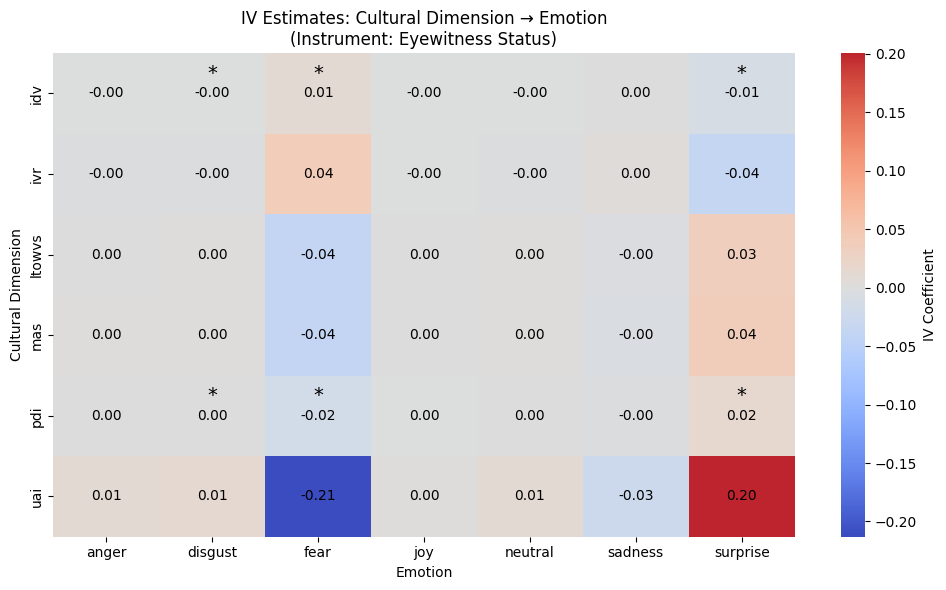

In [32]:
from statsmodels.stats.multitest import multipletests

results = []
for cult in culture_cols:
    for emo in emotion_cols:
        sub = df[[cult, emo, 'is_direct']].dropna()
        
        y = sub[emo]
        X = sm.add_constant(pd.DataFrame(index=sub.index))  
        
        endog = sub[[cult]]
        instr = sub[['is_direct']]
        
        iv_mod = IV2SLS(y, X, endog, instr).fit(cov_type='robust')
        coef = iv_mod.params[cult]
        pval = iv_mod.pvalues[cult]
        results.append({
            'culture': cult,
            'emotion': emo,
            'coef': coef,
            'pval': pval
        })

iv_df = pd.DataFrame(results)

# Apply Holm-Bonferroni correction
_, pvals_adj, _, _ = multipletests(iv_df['pval'], method='holm')

# Add adjusted p-values to results
iv_df['pval_adj'] = pvals_adj

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Draw heatmap with no annotations
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    coef_mat,
    cmap='coolwarm',
    center=0,
    annot=False,        # ← turn off automatic annot
    cbar_kws={'label': 'IV Coefficient'}
)

# 2. Manually annotate coefficients (centered)
for i, cult in enumerate(coef_mat.index):
    for j, emo in enumerate(coef_mat.columns):
        coef = coef_mat.loc[cult, emo]
        ax.text(
            j + 0.5, i + 0.5,
            f"{coef:.2f}",
            ha='center', va='center',
            color='black'
        )

# 3. Manually annotate stars (just above the number)
for i, cult in enumerate(coef_mat.index):
    for j, emo in enumerate(coef_mat.columns):
        # Add stars for significant results
        if iv_df.loc[(iv_df['culture'] == cult) & (iv_df['emotion'] == emo), 'pval_adj'].values < 0.05:
            ax.text(
                j + 0.5, i + 0.25,   # lower the y‐coord so the star sits above
                '*',
                ha='center', va='center',
                color='black',
                fontsize=14
            )

plt.title("IV Estimates: Cultural Dimension → Emotion\n(Instrument: Eyewitness Status)")
plt.xlabel("Emotion")
plt.ylabel("Cultural Dimension")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

records = []
for cult in culture_cols:
    for emo in emotion_cols:
        sub = df[[cult, emo, 'is_direct']].dropna()
        n = len(sub)

        y = sub[emo]
        X = sm.add_constant(pd.DataFrame(index=sub.index))
        endog = sub[[cult]]
        instr = sub[['is_direct']]

        # Second stage：IV 2SLS regression
        iv_mod = IV2SLS(y, X, endog, instr).fit(cov_type='robust')

        # First：manual regression
        first_stage_model = sm.OLS(sub[cult], sm.add_constant(sub[['is_direct']])).fit()
        fs_coef = first_stage_model.params['is_direct']
        fs_pval = first_stage_model.pvalues['is_direct']
        fs_fstat = float(first_stage_model.fvalue)
        fs_f_pval = float(first_stage_model.f_pvalue)

        
        ss_coef = iv_mod.params.get(cult, np.nan)
        ss_pval = iv_mod.pvalues.get(cult, np.nan)

        records.append({
            'culture': cult,
            'emotion': emo,
            'nobs': n,
            'fs_coef': fs_coef,
            'fs_pval': fs_pval,
            'fs_F': fs_fstat,
            'fs_F_pval': fs_f_pval,
            'ss_coef': ss_coef,
            'ss_pval': ss_pval
        })

iv_summary = pd.DataFrame(records)

# Print results
print(iv_summary.to_string(index=False))


culture  emotion  nobs    fs_coef      fs_pval      fs_F    fs_F_pval   ss_coef  ss_pval
    pdi    anger   321  11.952835 1.416310e-06 24.166275 1.416310e-06  0.000812 0.045709
    pdi  disgust   321  11.952835 1.416310e-06 24.166275 1.416310e-06  0.001149 0.000882
    pdi     fear   321  11.952835 1.416310e-06 24.166275 1.416310e-06 -0.016650 0.000078
    pdi      joy   321  11.952835 1.416310e-06 24.166275 1.416310e-06  0.000176 0.734010
    pdi  neutral   321  11.952835 1.416310e-06 24.166275 1.416310e-06  0.000860 0.214767
    pdi  sadness   321  11.952835 1.416310e-06 24.166275 1.416310e-06 -0.002022 0.051508
    pdi surprise   321  11.952835 1.416310e-06 24.166275 1.416310e-06  0.015673 0.000016
    idv    anger   321 -17.572082 7.748614e-09 35.199010 7.748614e-09 -0.000553 0.038244
    idv  disgust   321 -17.572082 7.748614e-09 35.199010 7.748614e-09 -0.000782 0.000517
    idv     fear   321 -17.572082 7.748614e-09 35.199010 7.748614e-09  0.011325 0.000015
    idv      joy   32

In [18]:
iv_summary.to_excel("IV_results.xlsx")

In [17]:
print(iv_mod.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:               surprise   R-squared:                     -5.2485
Estimator:                    IV-2SLS   Adj. R-squared:                -5.2680
No. Observations:                 321   F-statistic:                    5.0906
Date:                Tue, May 13 2025   P-value (F-stat)                0.0241
Time:                        09:35:32   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.0979     0.8405     2.4960     0.0126      0.4506      3.7452
ivr           -0.0365     0.0162    -2.2562     0.02

#### NEw IV

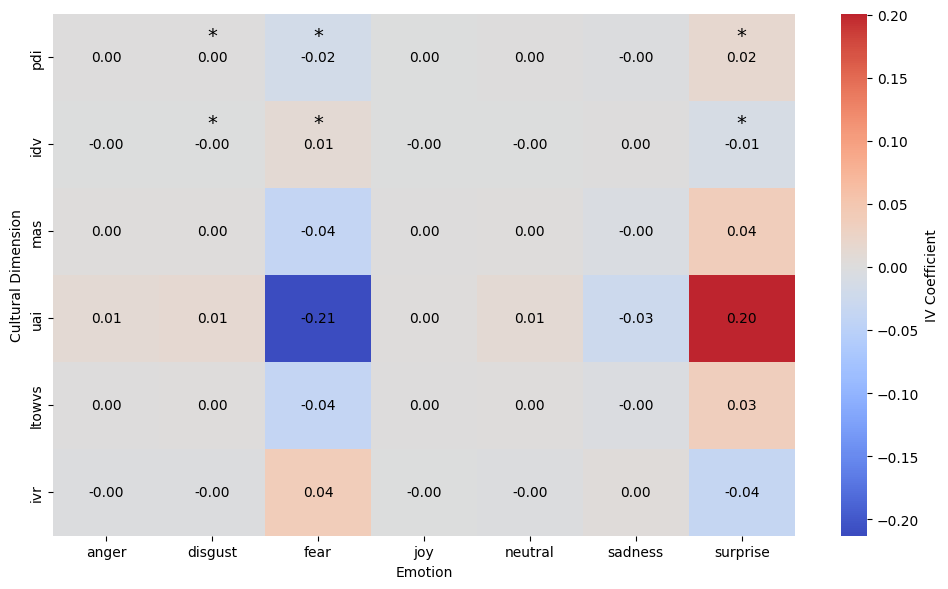

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

# Load dataset
df_further_final = pd.read_excel('data_cleaned_final_official.xlsx')
df = df_further_final.copy()

# Define emotion and cultural dimension columns
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
culture_cols = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']

# Drop rows with missing values
df = df.dropna(subset=['label'] + culture_cols + emotion_cols)

# Create a binary variable indicating direct eyewitness
df['is_direct'] = (df['label'] == 'direct-eyewitness').astype(int)

# Store IV regression results
results = []

# Run IV regression for each (culture, emotion) pair
for cult in culture_cols:
    for emo in emotion_cols:
        sub = df[[cult, emo, 'is_direct']].dropna()

        y = sub[emo]
        X = sm.add_constant(pd.DataFrame(index=sub.index))  # Constant only
        endog = sub[[cult]]  # Endogenous regressor
        instr = sub[['is_direct']]  # Instrument

        iv_mod = IV2SLS(y, X, endog, instr).fit(cov_type='robust')
        coef = iv_mod.params.get(cult, float('nan'))
        pval = iv_mod.pvalues.get(cult, float('nan'))

        results.append({
            'culture': cult,
            'emotion': emo,
            'coef': coef,
            'pval': pval
        })

# Convert results to DataFrame
iv_df = pd.DataFrame(results)

# Apply Holm-Bonferroni correction
_, pvals_adj, _, _ = multipletests(iv_df['pval'], method='holm')
iv_df['pval_adj'] = pvals_adj

# Construct coefficient matrix for heatmap
coef_matrix = []
for cult in culture_cols:
    row = []
    for emo in emotion_cols:
        coef = iv_df.loc[(iv_df['culture'] == cult) & (iv_df['emotion'] == emo), 'coef'].values[0]
        row.append(coef)
    coef_matrix.append(row)

coef_mat = pd.DataFrame(coef_matrix, columns=emotion_cols, index=culture_cols)

# Plot heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    coef_mat,
    cmap='coolwarm',
    center=0,
    annot=False,
    cbar_kws={'label': 'IV Coefficient'}
)

# Annotate coefficient values
for i, cult in enumerate(coef_mat.index):
    for j, emo in enumerate(coef_mat.columns):
        coef = coef_mat.loc[cult, emo]
        ax.text(j + 0.5, i + 0.5, f"{coef:.2f}", ha='center', va='center', color='black')

# Annotate significance with asterisk
for i, cult in enumerate(coef_mat.index):
    for j, emo in enumerate(coef_mat.columns):
        p_adj = iv_df.loc[(iv_df['culture'] == cult) & (iv_df['emotion'] == emo), 'pval_adj'].values[0]
        if p_adj < 0.05:
            ax.text(j + 0.5, i + 0.25, '*', ha='center', va='center', color='black', fontsize=14)

# Customize axis and layout
plt.xlabel("Emotion")
plt.ylabel("Cultural Dimension")
plt.title("IV Estimates: Cultural Dimension → Emotion\n(Instrument: Eyewitness Status)")
plt.tight_layout()
plt.show()